---

## Задача поиска схожих по смыслу предложений

Мы будем ранжировать вопросы [StackOverflow](https://stackoverflow.com) на основе семантического векторного представления

До этого в курсе не было речи про задачу ранжировния, поэтому введем математическую формулировку

## Задача ранжирования(Learning to Rank)

* $X$ - множество объектов
* $X^l = \{x_1, x_2, ..., x_l\}$ - обучающая выборка
<br>На обучающей выборке задан порядок между некоторыми элементами, то есть нам известно, что некий объект выборки более релевантный для нас, чем другой:
* $i \prec j$ - порядок пары индексов объектов на выборке $X^l$ c индексами $i$ и $j$
### Задача:
построить ранжирующую функцию $a$ : $X \rightarrow R$ такую, что
$$i \prec j \Rightarrow a(x_i) < a(x_j)$$

<img src="https://d25skit2l41vkl.cloudfront.net/wp-content/uploads/2016/12/Featured-Image.jpg" width=500, height=450>

### Embeddings

Будем использовать предобученные векторные представления слов на постах Stack Overflow.<br>
[A word2vec model trained on Stack Overflow posts](https://github.com/vefstathiou/SO_word2vec)

In [ ]:
!wget https://zenodo.org/record/1199620/files/SO_vectors_200.bin?download=1

--2023-10-06 18:34:37--  https://zenodo.org/record/1199620/files/SO_vectors_200.bin?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1453905423 (1.4G) [application/octet-stream]
Saving to: ‘SO_vectors_200.bin?download=1.1’

SO_vectors_200.bin? 100%[===================>]   1.35G  19.3MB/s    in 13m 19s 

2023-10-06 18:47:57 (1.74 MB/s) - ‘SO_vectors_200.bin?download=1.1’ saved [1453905423/1453905423]



In [ ]:
from gensim.models.keyedvectors import KeyedVectors
wv_embeddings = KeyedVectors.load_word2vec_format("SO_vectors_200.bin?download=1.1", binary=True)

#### Как пользоваться этими векторами?

Посмотрим на примере одного слова, что из себя представляет embedding

In [ ]:
word = 'dog'
if word in wv_embeddings:
    print(wv_embeddings[word].dtype, wv_embeddings[word].shape)

float32 (200,)


In [ ]:
print(f"Num of words: {len(wv_embeddings.index_to_key)}")

Num of words: 1787145


Найдем наиболее близкие слова к слову `dog`:

#### Вопрос 1:
* Входит ли слов `cat` топ-5 близких слов к слову `dog`? Какое место?

In [ ]:
# method most_simmilar
def most_simmilar(origin, similie, num): # similie может принимать список значений
  similar_words = wv_embeddings.most_similar(origin)
  return [(similar_words[i], i+1) for i in range(num) if similar_words[i][0] in similie]

most_simmilar('dog', ['cats', 'cat'], 5) # слова cat нет в похожих на dog словах

[(('cats', 0.7621253728866577), 4)]

### Векторные представления текста

Перейдем от векторных представлений отдельных слов к векторным представлениям вопросов, как к **среднему** векторов всех слов в вопросе. Если для какого-то слова нет предобученного вектора, то его нужно пропустить. Если вопрос не содержит ни одного известного слова, то нужно вернуть нулевой вектор.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import re

In [ ]:
class MyTokenizer:
    def __init__(self):
        pass
    def tokenize(self, text):
        text = re.findall('\w+', text)
        return [word.lower() for word in text]
tokenizer = MyTokenizer()

In [ ]:
def question_to_vec(question, embeddings, tokenizer, dim=200):
  words = tokenizer.tokenize(question)
  vectorized_question = np.zeros(dim)
  for word in words:
    if word in embeddings:
      vectorized_question += embeddings[word]
  return vectorized_question

Теперь у нас есть метод для создания векторного представления любого предложения.

#### Вопрос 2:
* Какая третья(с индексом 2) компонента вектора предложения `I love neural networks` (округлите до 2 знаков после запятой)?

In [ ]:
question = 'I love neural networks'
a = question_to_vec(question, wv_embeddings, tokenizer)
# np.around(a[2], 2)
round(a[2], 2)

-3.86

In [ ]:
cat = question_to_vec("Cats are good", wv_embeddings, tokenizer)
dog = [question_to_vec("Dogs are not good", wv_embeddings, tokenizer), question_to_vec("I really like dogs, they are the best", wv_embeddings, tokenizer)]
cosine_similarity([cat], dog)

array([[0.97391713, 0.71441503]])

### Оценка близости текстов

Представим, что мы используем идеальные векторные представления слов. Тогда косинусное расстояние между дублирующими предложениями должно быть меньше, чем между случайно взятыми предложениями.

Сгенерируем для каждого из $N$ вопросов $R$ случайных отрицательных примеров и примешаем к ним также настоящие дубликаты. Для каждого вопроса будем ранжировать с помощью нашей модели $R + 1$ примеров и смотреть на позицию дубликата. Мы хотим, чтобы дубликат был первым в ранжированном списке.

#### Hits@K
Первой простой метрикой будет количество корректных попаданий для какого-то $K$:
$$ \text{Hits@K} = \frac{1}{N}\sum_{i=1}^N \, [rank\_q_i^{'} \le K],$$
* $\begin{equation*}
[x < 0 ] \equiv
 \begin{cases}
   1, &x < 0\\
   0, &x \geq 0
 \end{cases}
\end{equation*}$ - индикаторная функция
* $q_i$ - $i$-ый вопрос
* $q_i^{'}$ - его дубликат
* $rank\_q_i^{'}$ - позиция дубликата в ранжированном списке ближайших предложений для вопроса $q_i$.

#### DCG@K
Второй метрикой будет упрощенная DCG метрика, учитывающая порядок элементов в списке путем домножения релевантности элемента на вес равный обратному логарифму номера позиции::
$$ \text{DCG@K} = \frac{1}{N} \sum_{i=1}^N\frac{1}{\log_2(1+rank\_q_i^{'})}\cdot[rank\_q_i^{'} \le K],$$
С такой метрикой модель штрафуется за большой ранк корректного ответа

#### Вопрос 3:
* Максимум `Hits@47 - DCG@1`?

In [ ]:
# 1/N*sum = x
#Hits@47 = sum(x)
# так как K = 1 для DCG, то DCG@1 может принимать только два значения: log2(1)*1/N и log2(2)*1/N
# т.е. значения 0 и 1 (1 если хотя бы один rank_qi равен 1)
# значит максимум HITS@47 - DCG@1 может достигаться только в случае, когда
# N максимальная для того, чтобы элемент суммы HITS@47 не был равен 0
# и DCG@1 был равен 0, причем rank_qi не должен быть меньше 47
# для N = 46 с позициями (2, 48) это значение будет равно 46/46 - 0/46 = 1,
# для N = 47 с позициями (1, 48) это значение будет равно 47/47 - 1/47 =~ 0.97,
# для N = 48 с позициями (1, 49) это значение будет равно 47/48 - 1/48 = 46/48 =~ 0.95,
# для N = 48 с позициями (2, 50) это значение будет равно 46/48 =~ 0.95,
# для N = 1 с позицией (3) это значение будет равно 1/1 - 0/1 = 1.
# итого максимум равен 1 и он достигается при N <=46 и rank_qi = range(2, 48)

<img src='https://hsto.org/files/1c5/edf/dee/1c5edfdeebce4b71a86bdf986d9f88f2.jpg' width=400, height=200>

#### Пример оценок

Вычислим описанные выше метрики для игрушечного примера.
Пусть
* $N = 1$, $R = 3$
* <font color='green'>"Что такое python?"</font> - вопрос $q_1$
* <font color='red'>"Что такое язык python?"</font> - его дубликат $q_i^{'}$

Пусть модель выдала следующий ранжированный список кандидатов:

1. "Как изучить с++?"
2. <font color='red'>"Что такое язык python?"</font>
3. "Хочу учить Java"
4. "Не понимаю Tensorflow"

$\Rightarrow rank\_q_i^{'} = 2$

Вычислим метрику *Hits@K* для *K = 1, 4*:

- [K = 1] $\text{Hits@1} =  [rank\_q_i^{'} \le 1)] = 0$
- [K = 4] $\text{Hits@4} =  [rank\_q_i^{'} \le 4] = 1$

Вычислим метрику *DCG@K* для *K = 1, 4*:
- [K = 1] $\text{DCG@1} = \frac{1}{\log_2(1+2)}\cdot[2 \le 1] = 0$
- [K = 4] $\text{DCG@4} = \frac{1}{\log_2(1+2)}\cdot[2 \le 4] = \frac{1}{\log_2{3}}$

#### Вопрос 4:
* Вычислите `DCG@10`, если $rank\_q_i^{'} = 9$(округлите до одного знака после запятой)

In [ ]:
round(1/np.log2(1+9)*(9<=10), 1)

0.3

### HITS\_COUNT и DCG\_SCORE

Каждая функция имеет два аргумента: $dup\_ranks$ и $k$. $dup\_ranks$ является списком, который содержит рейтинги дубликатов(их позиции в ранжированном списке). Например, $dup\_ranks = [2]$ для примера, описанного выше.

In [ ]:
def hits_count(dup_ranks, k):
    hits_value = []
    for rank in dup_ranks:
      hits_value.append(int(rank<=k))
    return sum(hits_value)

In [ ]:
def dcg_score(dup_ranks, k):
    dcg_value = []
    for rank in dup_ranks:
      dcg_value.append(1/(np.log2(1+rank))*(rank<=k))
    return sum(dcg_value)

Протестируем функции. Пусть $N = 1$, то есть один эксперимент. Будем искать копию вопроса и оценивать метрики.

In [ ]:
import pandas as pd

In [ ]:
copy_answers = ["How does the catch keyword determine the type of exception that was thrown",]

# наги кандидаты
candidates_ranking = [["How Can I Make These Links Rotate in PHP",
                       "How does the catch keyword determine the type of exception that was thrown",
                       "NSLog array description not memory address",
                       "PECL_HTTP not recognised php ubuntu"],]
# dup_ranks — позиции наших копий, так как эксперимент один, то этот массив длины 1
dup_ranks = [2]

# вычисляем метрику для разных k
print('Ваш ответ HIT:', [hits_count(dup_ranks, k) for k in range(1, 5)])
print('Ваш ответ DCG:', [np.around(dcg_score(dup_ranks, k), 5) for k in range(1, 5)])

Ваш ответ HIT: [0, 1, 1, 1]
Ваш ответ DCG: [0.0, 0.63093, 0.63093, 0.63093]


У вас должно получиться

In [ ]:
# correct_answers - метрика для разных k
correct_answers = pd.DataFrame([[0, 1, 1, 1], [0, 1 / (np.log2(3)), 1 / (np.log2(3)), 1 / (np.log2(3))]],
                               index=['HITS', 'DCG'], columns=range(1,5))
correct_answers

,1,2,3,4
HITS,0,1.00000,1.00000,1.00000
DCG,0,0.63093,0.63093,0.63093


### Данные
[arxiv link](https://drive.google.com/file/d/1QqT4D0EoqJTy7v9VrNCYD-m964XZFR7_/edit)

`train.tsv` - выборка для обучения.<br> В каждой строке через табуляцию записаны: **<вопрос>, <похожий вопрос>**

`validation.tsv` - тестовая выборка.<br> В каждой строке через табуляцию записаны: **<вопрос>, <похожий вопрос>, <отрицательный пример 1>, <отрицательный пример 2>, ...**

In [ ]:
!unzip /content/stackoverflow_similar_questions.zip

Archive:  /content/stackoverflow_similar_questions.zip
   creating: data/
  inflating: data/.DS_Store          
   creating: __MACOSX/
   creating: __MACOSX/data/
  inflating: __MACOSX/data/._.DS_Store  
  inflating: data/train.tsv          
  inflating: data/validation.tsv     


Считайте данные.

In [ ]:
def read_corpus(filename):
    data = []
    for line in open(filename, encoding='utf-8'):
        data.append(line.strip())
    return data

Нам понадобиться только файл validation.

In [ ]:
validation_data = read_corpus('./data/validation.tsv')

Кол-во строк

In [ ]:
len(validation_data)

3760

Размер нескольких первых строк

In [ ]:
for i in range(5):
    print(i + 1, len(validation_data[i]))

1 54516
2 52817
3 54463
4 53723
5 52296


### Ранжирование без обучения

Реализуйте функцию ранжирования кандидатов на основе косинусного расстояния. Функция должна по списку кандидатов вернуть отсортированный список пар (позиция в исходном списке кандидатов, кандидат). При этом позиция кандидата в полученном списке является его рейтингом (первый - лучший). Например, если исходный список кандидатов был [a, b, c], и самый похожий на исходный вопрос среди них - c, затем a, и в конце b, то функция должна вернуть список **[(2, c), (0, a), (1, b)]**.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from copy import deepcopy
from collections import Counter

In [ ]:
def rank_candidates(question, candidates, embeddings, tokenizer, dim=200):
  question_vec = question_to_vec(question, embeddings, tokenizer, dim)
  candidates_vec = [question_to_vec(candidate, embeddings, tokenizer, dim) for candidate in candidates]
  result = cosine_similarity([question_vec], candidates_vec)[0]
  sorted_result = sorted(enumerate(candidates), key=lambda x: result[x[0]], reverse=True)
  return sorted_result

Протестируйте работу функции на примерах ниже. Пусть $N=2$, то есть два эксперимента

In [ ]:
questions = ['converting string to list', 'Sending array via Ajax fails']

candidates = [['Convert Google results object (pure js) to Python object', # первый эксперимент
               'C# create cookie from string and send it to',
               'How to use jQuery AJAX for an outside domain?'],

              ['Getting all list items of an unordered list in PHP',      # второй эксперимент
               'WPF- How to update the changes in list item of a list',
               'select2 not displaying search results']]

In [ ]:
for question, q_candidates in zip(questions, candidates):
        ranks = rank_candidates(question, q_candidates, wv_embeddings, tokenizer)
        print(ranks)
        print()

[(1, 'C# create cookie from string and send it to'), (0, 'Convert Google results object (pure js) to Python object'), (2, 'How to use jQuery AJAX for an outside domain?')]

[(0, 'Getting all list items of an unordered list in PHP'), (2, 'select2 not displaying search results'), (1, 'WPF- How to update the changes in list item of a list')]



Для первого экперимента вы можете полностью сравнить ваши ответы и правильные ответы. Но для второго эксперимента два ответа на кандидаты будут <b>скрыты</b>(*)

In [ ]:
# должно вывести
results = [[(1, 'C# create cookie from string and send it'),
            (0, 'Convert Google results object (pure js) to Python object'),
            (2, 'How to use jQuery AJAX for an outside domain?')]]
          #  [(*, 'Getting all list items of an unordered list in PHP'), #скрыт
          #   (*, 'select2 not displaying search results'), #скрыт
          #   (*, 'WPF- How to update the changes in list item of a list')]] #скрыт

#### Вопрос 5:
* Какую последовательность начальных индексов вы получили `для эксперимента 2`(перечисление без запятой и пробелов, например, `102` для первого эксперимента?

In [ ]:
print("для первого: 102, для второго: 021")

для первого: 102, для второго: 021


Теперь мы можем оценить качество нашего метода. Запустите следующие два блока кода для получения результата. Обратите внимание, что вычисление расстояния между векторами занимает некоторое время (примерно 10 минут). Можете взять для validation 1000 примеров.

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
wv_ranking = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, wv_embeddings, tokenizer)
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)

  0%|          | 0/3760 [00:00<?, ?it/s]

In [ ]:
for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 372.000 | Hits@   1: 372.000
DCG@   5: 372.000 | Hits@   5: 372.000
DCG@  10: 372.000 | Hits@  10: 372.000
DCG@ 100: 372.000 | Hits@ 100: 372.000
DCG@ 500: 372.392 | Hits@ 500: 375.000
DCG@1000: 372.700 | Hits@1000: 378.000


### Эмбеддинги, обученные на корпусе похожих вопросов

In [ ]:
train_data = read_corpus('./data/train.tsv')

In [ ]:
train_data[:5]

['converting string to list\tConvert Google results object (pure js) to Python object',
 'Which HTML 5 Canvas Javascript to use for making an interactive drawing tool?\tEvent handling for geometries in Three.js?',
 'Sending array via Ajax fails\tGetting all list items of an unordered list in PHP',
 'How to insert CookieCollection to CookieContainer?\tC# create cookie from string and send it',
 'Updating one element of a bound Observable collection\tWPF- How to update the changes in list item of a list']

#### Очистка данных

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
stem = SnowballStemmer('english')
lemma = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [ ]:
def cleanalyzer(text):
    text = (re.sub(r'\d+', '', text)).lower()
    text = word_tokenize(text)
    text = [lemma.lemmatize(word) for word in text if word not in stop_words] # приводим слова, не относящиеся к стоп-словам, к лемме
    text = [word for word in text if len(word) > 3 and len(word) < 30]
    text = [stem.stem(word) for word in text]
    # text = ' '.join(text)
    return text

In [ ]:
train = pd.Series(train_data)
train = train.apply(cleanalyzer)

In [ ]:
train.shape, train.head()

((1000000,),
 0    [convert, string, list, convert, googl, result...
 1    [html, canva, javascript, make, interact, draw...
 2    [send, array, ajax, fail, get, list, item, uno...
 3    [insert, cookiecollect, cookiecontain, creat, ...
 4    [updat, element, bound, observ, collect, wpf-,...
 dtype: object)

#### Обучение модели и оценка близости

Улучшите качество модели.<br>Склеим вопросы в пары и обучим на них модель Word2Vec из gensim. Выберите размер window. Объясните свой выбор.

In [ ]:
from gensim.models import Word2Vec

Окна большего размера, как правило, содержат больше информации о теме: какие еще слова используются в соответствующих обсуждениях? Окна меньшего размера, как правило, позволяют больше узнать о самом слове: какие еще слова функционально похожи?\
\
Нам необходимо найти окно такого размера, чтобы модель могла уловить контекст и суть слов (при этом при окне большего размера последует переобучение, а при окне меньшего размера - недообучение)\
\
Допустим, у нас есть предложение "Финансовый университет набирает умных студентов". Если размер окна будет, например, равен 2, то слово "университет" будет векторно приближаться к словам "Финансовый" и "набирает", однако, если размер окна равен, к примеру, 5, то "университет" будет векторно приближаться ко всем словам данного предложения: "университет"-"студент", "университет"-"умный".

In [ ]:
embeddings_trained = Word2Vec(train,      # train data
                 vector_size=200,         # embedding vector size
                 min_count=5,             # consider words that occured at least 5 times
                 window=3).wv

Выбор пал на размер 3, т.к. датасет состоит из StackOverflow вопросов, не имеющих, как правило, достаточной длины текста, но имеющих свой четко выделенный контекст.

In [ ]:
wv_ranking = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, embeddings_trained, tokenizer)
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)

  0%|          | 0/3760 [00:00<?, ?it/s]

In [ ]:
for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 1000.000 | Hits@   1: 1000.000
DCG@   5: 1000.000 | Hits@   5: 1000.000
DCG@  10: 1000.000 | Hits@  10: 1000.000
DCG@ 100: 1000.000 | Hits@ 100: 1000.000
DCG@ 500: 1000.000 | Hits@ 500: 1000.000
DCG@1000: 1000.000 | Hits@1000: 1000.000


In [ ]:
[embeddings_trained.most_similar("list")[i][0] for i in range(3)]

['arraylist', 'tupl', 'dictionari']

#### Обучение модели по заданию для сравнения:

In [ ]:
train2 = pd.Series(train_data)
train2 = train2.apply(tokenizer.tokenize)

In [ ]:
embeddings_trained2 = Word2Vec(train2,      # train data
                 vector_size=200,         # embedding vector size
                 min_count=5,             # consider words that occured at least 5 times
                 window=3).wv

In [ ]:
wv_ranking2 = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, embeddings_trained2, tokenizer)
    wv_ranking2.append([r[0] for r in ranks].index(0) + 1)

  0%|          | 0/3760 [00:00<?, ?it/s]

In [ ]:
for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking2, k), k, hits_count(wv_ranking2, k)))

  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 7.000 | Hits@   1: 7.000
DCG@   5: 7.000 | Hits@   5: 7.000
DCG@  10: 7.000 | Hits@  10: 7.000
DCG@ 100: 7.000 | Hits@ 100: 7.000
DCG@ 500: 7.401 | Hits@ 500: 10.000
DCG@1000: 7.503 | Hits@1000: 11.000


### Замечание:
Решить эту задачу с помощью обучения полноценной нейронной сети будет вам предложено, как часть задания в одной из домашних работ по теме "Диалоговые системы".

Напишите свой вывод о полученных результатах.
* Какой принцип токенизации даёт качество лучше и почему?
* Помогает ли нормализация слов?
* Какие эмбеддинги лучше справляются с задачей и почему?
* Почему получилось плохое качество решения задачи?
* Предложите свой подход к решению задачи.

## Вывод:


Можно заметить, что модель обучена более, чем достаточно. Высокое качество решения задачи получилось благодаря нормализации текста (токенизации, лемматизации, стемингу, использованию стоп-слов), несмотря на бОльшую затратность по времени, т.к. датасет включал в себя 10000 строк.

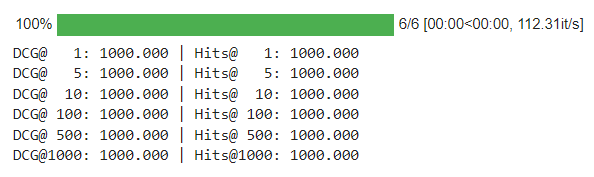

Для сравнения мы обучили модель по инструкции, не применяя нормализации текста вообще, только токенизируя его. Тестовые и трейновые данные выбраны те же, однако без нормализации качество модели значительно ухудшилось:

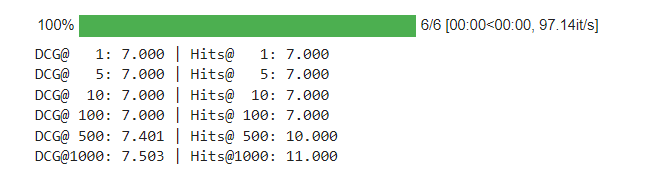